# Atomic Experiments in Deep Learning

_Deep Learning has been compared to electricity. I'd like to provide another analogy: alchemy._ -- Ali Rahimi, NIPS 2017

* Deep learning remains somewhat of a mysterious art even for frequent practitioners, because we usually run complex experiments on large datasets, which obscures basic relationships between dataset, hyperparameters, and performance.
* The goal of this notebook is to provide some basic intuition of deep neural networks by running very simple experiments on small datasets that help understand trends that occur generally on larger datasets. The experiments are designed to be "atomic" in that they try to test one fundamental aspect of deep learning in a controlled way. Furthermore, the experiments do not require specialized hardware (they all run in a few minutes without GPUs. See the elapsed time, measured on a CPU-only machine).
* All of the experiments here are written in Python using the [tensorflow](https://www.tensorflow.org/) and [sklearn](http://scikit-learn.org) libraries, but most of the code has been abstracted away to make the experiments easier to run. See the accompanying `utils.py` file for full code. 

In [1]:
import sys, os; sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('global_utils'))))
from global_utils import *
from utils import *

import tensorflow as tf, numpy as np
import matplotlib.pyplot as plt
pretty_plotting_styles()
timer = Timer()

%load_ext autoreload
%autoreload 2
%matplotlib inline

# I. Basics 

## 1. Why Use Neural Networks in the First Place?

The [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem), states that a simple feedforward neural network (i.e. a multilayer perceptron) with a single hidden layer and a standard activation function can approximate any continuous function, if the hidden layer has a sufficient number of units. Let's show this in practice by seeing how many units it takes to approximate some select functions.

**Method:** We'll train a 1-layer neural network on 50 datapoints $(x,y)$ that are drawn from the following functions on the domain $[-1,1]$, and measure the mean square error (MSE) of the resulting fit. We'll try out the following functions (feel free to try your own!):

$$f(x) = \sin(12x)$$

$$g(x) = -2x^4 + x^3 + x^2 - 2x + 0$$

$$ h(x) = \lvert x \rvert$$


**Hypothesis:** As the number of units in the hidden layer increases, the accuracy of the resulting fit will increase (error will decrease).

Elapsed time: 52.978 s


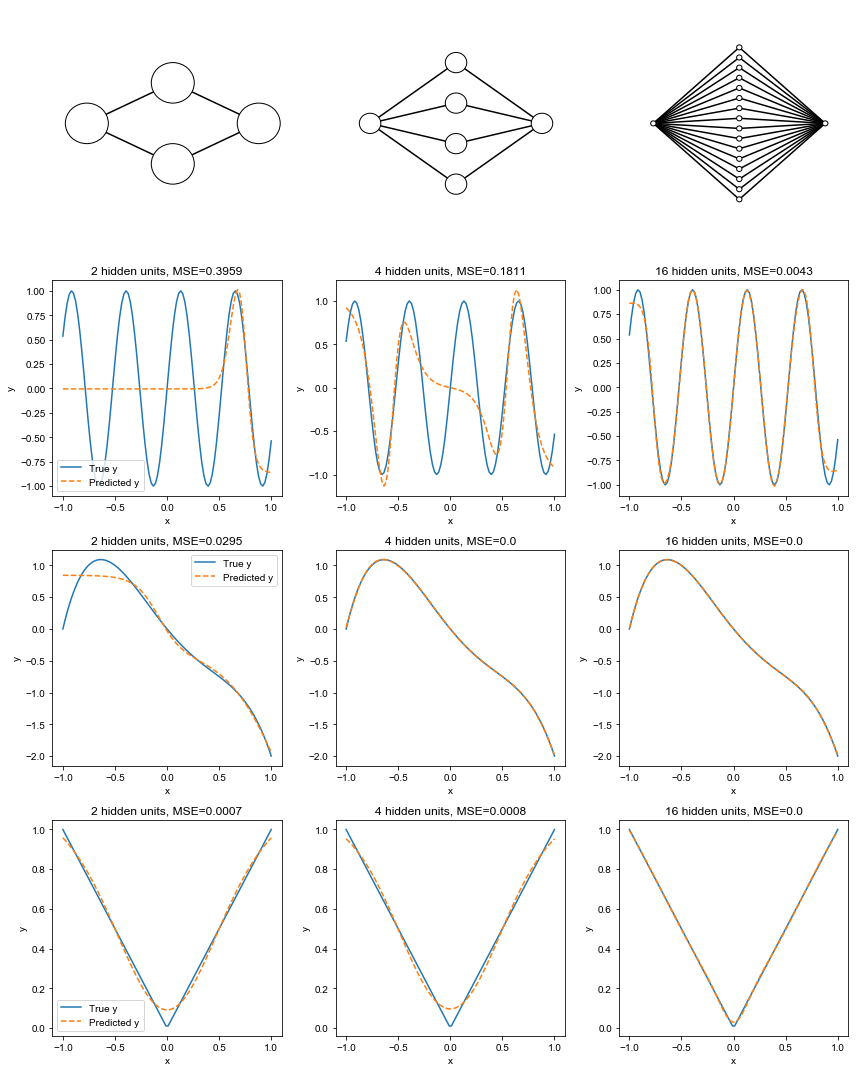

In [133]:
timer.start()
functions = (sin(omega=12),polynomial([0,-2,1,1,-2]),np.abs)
n_hidden_units = (2, 4, 16) 
experiment = Experiment1()

f, axs = plt.subplots(4,3,figsize=(12,15))
for i, n_hidden in enumerate(n_hidden_units):
    ax = axs[0, i]
    ax.axis('off')
    draw_neural_net(ax, .15, .9, .1, .85, [1, n_hidden, 1])


experiment.initialize()
plot_idx = 1
for i, function in enumerate(functions):
    for j, n_hidden in enumerate(n_hidden_units):
        x_values, y_values, y_pred, loss = experiment.run(n_hidden=n_hidden, function=function, verbose=False)
        ax = axs[i+1, j]
        ax.plot(x_values, y_values, '-',label='True y')
        ax.plot(x_values, y_pred, '--',label='Predicted y')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if (j==0):
            ax.legend()
        ax.set_title(str(n_hidden)+' hidden units, MSE='+str(np.round(loss,4)))
        
plt.tight_layout()
timer.end_and_print()

**Conclusion:** As the number of hidden units increase, the approximation error on the training data generally decreases. 

**Discussion:** Although the universal approximation theorem says that neural network with enough parameters can approximate a true classification/regression function, it doesn't say anything about whether these parameters are _learnable_ through a procedure like stochastic gradient descent. Additionally, you might be wondering whether we can theoretically calculate how many neurons are needed to approximate a given function arbitrarily well. See [(Mhaskar, 1996)](https://pdfs.semanticscholar.org/694a/d455c119c0d07036792b80abbf5488a9a4ca.pdf) for some discussion of this.

## 2. Why are Deeper Networks Better?

In practice, deeper multilayer perceptrons (with more than 1 hidden layer) outperform shallow ones by a wide margin on many task of interest. Why might this be the case? It has been suggested that deeper neural networks _require fewer parameters_ to express many important classes of functions. It has been shown theoretically that expressing [simple radial functions](https://arxiv.org/pdf/1512.03965.pdf) and [compositional functions](https://arxiv.org/pdf/1603.00988.pdf) requires an exponentially large number of parameters using shallow networks, but not so for deep neural networks. Spoiler alert: I tried to experimentally verify these papers, but I was not able to do so (this does not invalidate the results of the paper -- just because a set of neural network parameters exist, does not mean they can be learned easily by stochastic gradient descent). The only result I was able to reproduce even somewhat reliably was from a [paper that proposed a family of difficult classification problems](https://arxiv.org/pdf/1509.08101.pdf) that are easier for deeper neural networks. This is what I show here.

** Method:**  The dataset consists of 16 equally-spaced points along the x-axis, with each pair of ajacent points belonging to opposite classes. A special kind of deep neural network (one that shares weights across layers) with a fixed number (152) of parameters but varying numbers of layers is tested.

**Hypothesis:** As the number of layers increase in a neural network with a fixed number of parameters, the accuracy on a difficult classification problem will improve.

Elapsed time: 42.162 s


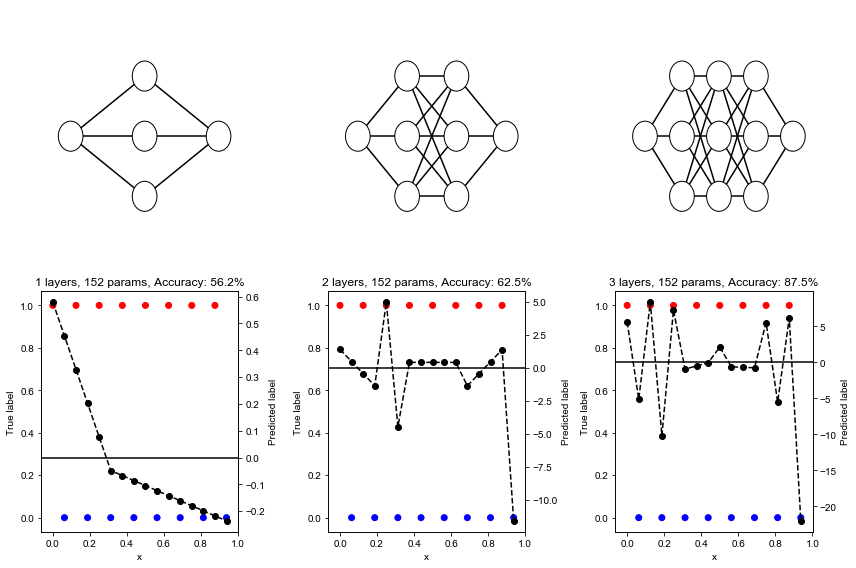

In [356]:
timer.start()
experiment = Experiment2()
experiment.initialize()

n_hidden_units = [[10],[10,10],[10,10,10]]

f, axs = plt.subplots(2,3,figsize=(12,8))

for i, n_hidden in enumerate(n_hidden_units):
    ax = axs[0, i]
    ax.axis('off')
    draw_neural_net(ax, .15, .9, .1, .85, [1] + [3]*len(n_hidden) + [1]) #10 hidden units per layer becomes too crowded

for i, n_hidden in enumerate(n_hidden_units):
    ax = axs[1, i]
    x_values,y_values,y_pred,loss,accuracy,n_params = experiment.run(n=16, n_hidden = n_hidden)
    ax.set_title(str(len(n_hidden))+' layers, '+str(n_params)+' params, Accuracy: '+str(np.round(100*accuracy,1))+'%')
    ax.set_xlabel('x')
    ax.set_ylabel('True label')
    ax.scatter(x_values, y_values[:,1], marker='o',c=y_values[:,1],cmap='bwr',label='Predicted y')
    ax2 = ax.twinx()
    ax2.plot(x_values, y_pred[:,1]-y_pred[:,0], 'k--o',label='Predicted y')
    ax2.axhline(0, color='k', ls='-')
    ax2.set_ylabel('Predicted label')

plt.tight_layout()
timer.end_and_print()

Here, red and blue dots represent points that belong to different classes. The dashed-dotted black line is the closest approximation to the training data that is learned by the neural network (if the neural network assigns a score greater than zero, then a point is considered to be predicted as belonging to the red class. Otherwise, it is predicted to be blue). The zero line is shown in black.

** Conclusion:** Accuracy increases with increasing depth in most runs of the experiments. 

** Discussion:** It seems that deeper layers allow more "sharp turns" in the learned function from the input to the output. This seems to be related to some work on the [trajectory length](https://arxiv.org/pdf/1606.05336.pdf) of neural networks (a measure of how much the output of a neural network travels as the input varies along a 1D path of fixed length).

# II. Data

## 3. Does More Data Favor Deeper Neural Networks?

Deep learning and big data are closely linked; it's usually said that deep learning only works better than other techniques (such as shallow neural networks and random forests) when the size of the dataset grows large enough to overcome overfitting, and favor the increased expressivity of deep networks. We investigate this on a very simple dataset, consisting of a mixture of Gaussian samples. 

** Method: ** The dataset consists of a mixture of two 12-dimensional Gaussians, each of which generate data belonging to one class. The two Gaussians have the same covariance matrix, but have means that are $1/i$ unit apart in the $i^\text{th}$ dimension. The idea is to have some dimensions that allow models to easily discriminate between classes, while other dimensions are more difficult, but still useful, for discrimination.

**Hypothesis:** As the size of dataset increases, the test accuracy of all of the techniques will improve, but the accuracy of deep models will grow more than the non-deep models. We further expect the accuracy of the non-deep learning techniques to saturate more quickly.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 

ns = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
test_size=0.2; train_size=1-test_size

class_seps = [1/(i+1) for i in range(12)]

classifiers = [SVC(),
               DecisionTreeClassifier(),
               MLPClassifier(),
               MLPClassifier(hidden_layer_sizes=(100,100)),
              ]

classifier_names = ['Support Vector Machine','Decision Trees','Shallow Network','Deep Network']

experiment = Experiment3()
experiment.initialize()

plt.figure(figsize=[6,6])
accuracies = experiment.run(ns=ns,classifiers=classifiers,class_seps=class_seps,d=12,iters=3, test_size=test_size)
plt.title('Test Accuracy of Various Classifiers')
plt.plot(train_size*np.array(ns), np.mean(accuracies,axis=2), '-o')
plt.xlabel('Training set size (n)')
plt.ylabel('Test Accuracy')
plt.xscale('log')
plt.legend(classifier_names)

experiment.conclude()

** Conclusion:** The neural networks consistently perform better than SVMs and random forests across dataset size. The gap in performance increases as dataset size increases in, at least until the accuracy of the neural networks begin to saturate, suggesting that the neural networks are more efficiently able to take advantage of increasing dataset size. However, with enough data, even SVMs have a respectable accuracy, approaching 1.0. Deep networks perform a little bit better than shallow networks.

** Discussion: ** Although increasing dataset size does tend to favor neural networks as we expected, it is interesting that the neural networks are already better than other techniques on relatively small datasets. It seems that the 2-layer network isn't significantly overfitting, even though we would expect some features (say features 6-12, which have low levels of signal) to cause the networks to overfit.

## 4. Do Extra Randomly-Labeled Training Examples Harm Neural Networks?

[Rolnick et al.](https://arxiv.org/abs/1705.10694) discovered a remarkable fact: when trained on MNIST and CIFAR-10, a deep neural network's performance hardly suffered even when, in addition to each real training examples, up to 99 randomly-labeled examples were included. This might be the case because early layers of a neural networks are able to learn basic structure of a dataset (in an unsupervised manner) even when labels are noisy/missing. We investigate this phenomenon here on a synthetic dataset, as well as a smaller version of the MNIST dataset, consisting only of the digits 0 and 1. 

**Method:** First, we use a synthetic dataset that consists of a mixture of two 12-dimensional Gaussians, which is generated the same way as in Experiment 3. The second dataset consists of a subset of MNIST images, only with the digits 0 and 1. For each dataset, we augment the the training set with a varying number of randomly-labeled training points. We also consider the order in which the randomly-labeled data are seen by the network. They can be seen _before_ the correctly-labeled data, _afterwards_, or in a _random_ order. Finally, we look at the performance of a support vector machine, a 1-layer MLP, and a 2-layer MLP.

** Hypothesis **: Based on the results of the aforementioned authors, we expect the test time accuracy of the deep network to not significantly degrade in the presence of the randomly-labeled data, especially when they are introduced in a random order. Wwe do expect the performance of the other techniques to suffer.

**Warning**: The ```sklearn``` implementation of ```MLPClassifier``` seems to be weirdly sensitive to the number of data points. So strange results will happen if n_fake=1 for example 

Elapsed time: 49.808 s


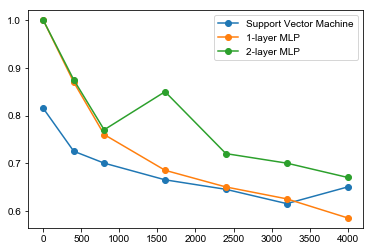

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 

experiment = Experiment4()
experiment.initialize()

classifiers = [SVC(),
               MLPClassifier(),
               MLPClassifier(hidden_layer_sizes=(100,100)),
              ]

classifier_names = ['Support Vector Machine','1-layer MLP','2-layer MLP']


n = 1000
test_size=0.2; train_size=1-test_size
n_fakes = n*np.array([0, 0.5, 1, 2, 3, 4, 5]) 
class_seps = [1/(i+1) for i in range(12)]

plt.figure()
accuracies = experiment.run(verbose=False,d=12,n=1000,class_seps=class_seps,n_fakes=n_fakes,classifiers=classifiers)
plt.plot(train_size*n_fakes, accuracies,'-o')
plt.legend(classifier_names)

experiment.conclude()

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist.train.images.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)

# Transfer Learning (as Dataset size increases)

# Multi-Task Learning

# What About Completely Random Labels?

# Do Neural Networks Memorize or Generalize?

# Should We Emphasize Certain Data Points During Training?

# Can Neural Networks Handle Imbalanced Datasets?

# III. Parameters and Hyperparameters

# How Do the Parameters Evolve?

# Does the Activation Function Matter?

- [Activation Functions] What if polynomials are used instead? What about Leakiness? What about sins?
http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html

# How Does Regularization Help a Neural Network? Dropout

http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html

# Does the Optimizer Matter?

# How Does Batching Effect the Results

- why log likelihood? What if you have two identical inputs in two different classes? Does the model break?


# Learning Rate and Momentum

Relationship between batch size and learning rate

# IV. Unsupervision

# Do Unhelpful Features Hurt? How Much?

# Does Unsupervised Feature Reduction Help or Hurt?

# V. Tricks

# Does Training a Neural Network End-to-End Help?

# Do Neural Networks Have Lots of Local Minima?

# What is Batch Normalization and Why Does it Help?

# How Much Does Data Augmentation Help?

# What about Initialization?

# Model Compression


* _Note:_ an alternative explanation for why deeper neural entworks It's not just that deeper networks are more _expressive_ than shallow networks, but a remarkable result is that they are easier to train.  
* Using a technique called [model compression](http://datascienceassn.org/sites/default/files/Do%20Deep%20Nets%20Really%20Need%20to%20be%20Deep.pdf), it's been shown that shallow networks that are trained to *mimic* deeper networks often do better than shallow networks trained on the data directly.

** _If this helped in your research, please cite it. An example bibtex entry is shown:_ **

```
@misc{abid2017atomic,
  title={20 Atomic Experiments in Deep Learning},
  author={Abid, Abubakar},
  year={2017},
  publisher={GitHub},
  howpublished={\url{https://github.com/abidlabs/AtomsOfDeepLearning}},
}
```